In [3]:
help("modules")


Please wait a moment while I gather a list of all available modules...



/Users/srensi/anaconda3/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/Users/srensi/anaconda3/lib/python2.7/site-packages/odo/backends/pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))
/Users/srensi/anaconda3/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/Users/srensi/anaconda3/lib/python2.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for f

Audio_mac           audioop             icglue              qtconsole
BaseHTTPServer      autoGIL             icopen              qtpy
Bastion             autoreload          idlelib             quopri
CGIHTTPServer       babel               idna                random
Canvas              backcall            ihooks              re
Carbon              backports           imageio             readline
CodeWarrior         backports_abc       imagesize           repr
ColorPicker         base64              imaplib             requests
ConfigParser        bdb                 imghdr              resource
Cookie              bgenlocations       imp                 rexec
Crypto              binascii            importlib           rfc822
Cython              binhex              imputil             rlcompleter
Dialog              binstar_client      inspect             rmagic
DocXMLRPCServer     bisect              io                  robotparser
EasyDialogs         bitarray            ipaddress   

/Users/srensi/anaconda3/lib/python2.7/pkgutil.py:125: VisibleDeprecationWarning: zmq.eventloop.minitornado is deprecated in pyzmq 14.0 and will be removed.
    Install tornado itself to use zmq with the tornado IOLoop.
    
  for item in walk_packages(path, name+'.', onerror):


In [2]:
import pandas as pd
from neo4j.v1 import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

ImportError: No module named neo4j.v1

In [74]:
uri="bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=('', ''))

In [75]:
query = """
    MATCH (c:Chemical)-[w]-(s)-[x]-(d:Document)-[y]-(t)-[z]-(p:Disease)
    WHERE d.year={year}
    MATCH (s)-[:HAS_THEME]-(j)
    RETURN c.name as chemical, (j.t)/(j.sa+5) as eff_score, p.name as disease
    LIMIT {limit}
"""

In [83]:
queryNoLim = """
    MATCH (c:Chemical)-[w]-(s)-[x]-(d:Document)-[y]-(t)-[z]-(p:Disease)
    WHERE d.year={year}
    MATCH (s)-[:HAS_THEME]-(j)
    RETURN c.name as chemical, (j.t)/(j.sa+5) as eff_score, p.name as disease
"""

In [94]:
with driver.session() as neo4j:
    results1 = neo4j.run(queryNoLim, {"year": 1993})
    results2 = neo4j.run(queryNoLim, {"year": 1994})

In [95]:
def neoResultsToDataFrame(results):
    out_net = dict()
    for record in results:
        if record['eff_score'] is None:
            continue
        edge_key = (record['chemical'], record["disease"])
        if edge_key in out_net:
            out_net[edge_key][0] += record['eff_score']
            out_net[edge_key][1] += 1
        else:
            out_net[edge_key] = [record['eff_score'], 1]
    test1 = pd.DataFrame(out_net).transpose()
    test1.fillna(method='backfill', inplace=True)
    test1.reset_index(inplace=True)
    test1.columns = ["source", "target", "weight", "count"]
    return(test1)

In [96]:
graph1 = neoResultsToDataFrame(results1)
graph2 = neoResultsToDataFrame(results2)

In [104]:
test = pd.merge(graph1, graph2, on=['source', 'target'])

,source,target,weight_x,count_x,weight_y,count_y
0,glucitol,diabetes,40,124,45,83
1,streptozocin,diabetes,18,369,81,428
2,streptozocin,impaired_renal_function,0,3,0,25
3,ICI_128436,diabetes,21,14,16,10
4,phorbol_ester,tumor,0,27,0,10


In [110]:
test['weight_x']

0        40
1        18
2         0
3        21
4         0
5        14
6         8
7        32
8         4
9         2
10       53
11        9
12      657
13      147
14        2
15       20
16        1
17        0
18       20
19       26
20        0
21        9
22      775
23      630
24      221
25      248
26      242
27      420
28      168
29        5
       ... 
6679      3
6680      0
6681      1
6682      0
6683      0
6684      0
6685      1
6686      0
6687     20
6688     19
6689      0
6690      0
6691     89
6692      0
6693      0
6694      9
6695      0
6696      0
6697      6
6698      0
6699      0
6700      0
6701      0
6702      3
6703      0
6704      0
6705      3
6706     21
6707      5
6708     13
Name: weight_x, Length: 6709, dtype: int64

In [111]:
test['diffWeight'] =  test['weight_y'] - test['weight_x']

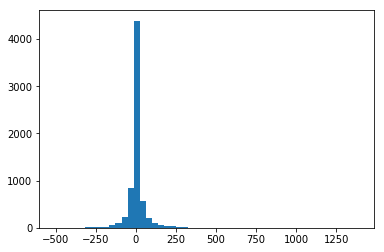

In [118]:
plt.hist(test['diffWeight'], bins=50)
plt.show()

In [119]:
max(test['diffWeight'])

1392

In [115]:
test[test['diffWeight'] == 1392]

,source,target,weight_x,count_x,weight_y,count_y,diffWeight
1171,paclitaxel,breast_tumor,225,29,1617,250,1392


In [120]:
min(test['diffWeight'])

-508

In [121]:
test[test['diffWeight'] == -508]

,source,target,weight_x,count_x,weight_y,count_y,diffWeight
5264,methotrexate,asthma,581,85,73,13,-508


In [139]:
startYear = 1995
endYear = 2005
with driver.session() as neo4j:
    diffStats = dict()
    prevYear = neoResultsToDataFrame(neo4j.run(queryNoLim, {"year": startYear}))
    startYear += 1
    timeStorage = None
    for i in range(startYear, endYear):
        print(i)
        curYear = neoResultsToDataFrame(neo4j.run(queryNoLim, {"year": i}))
        shared = pd.merge(prevYear, curYear, how='outer', on=['source', 'target'])
        shared['diffWeight'] =  shared['weight_y'] - shared['weight_x']
        prevYear = curYear
        if timeStorage is None:
            timeStorage = shared[['source', 'target', 'diffWeight']]
            timeStorage.columns = ["source", "target", "delta" + str(i)]
        else:
            shared = shared[['source', 'target', 'diffWeight']]
            shared.columns = ["source", "target", "delta" + str(i)]
            timeStorage = pd.merge(timeStorage, shared, how='outer')

1996
1997
1998
1999
2000
2001
2002
2003
2004


In [140]:
timeStorage.head()

,source,target,delta1996,delta1997,delta1998,delta1999,delta2000,delta2001,delta2002,delta2003,delta2004
0,echistatin,melanoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mivacurium,depresses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mivacurium,AFP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,edrophonium,AFP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,edrophonium,depresses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
timeStorage.to_csv("/Users/alavertu/Desktop/drugDeltas.csv")

In [145]:
timeDeltas = timeStorage.fillna(value=0)

In [146]:
timeDeltas.head()

,source,target,delta1996,delta1997,delta1998,delta1999,delta2000,delta2001,delta2002,delta2003,delta2004
0,echistatin,melanoma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,mivacurium,depresses,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,mivacurium,AFP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,edrophonium,AFP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,edrophonium,depresses,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
test = timeDeltas.iloc[:,2:].transpose()

In [154]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,136532,136533,136534,136535,136536,136537,136538,136539,136540,136541
delta1996,0.0,0.0,0.0,0.0,0.0,-86.0,-1.0,0.0,0.0,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delta1997,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,5.0,0.0,-113.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delta1998,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,1.0,0.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delta1999,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,-20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delta2000,0.0,0.0,0.0,0.0,0.0,-13.0,-1.0,0.0,4.0,-18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


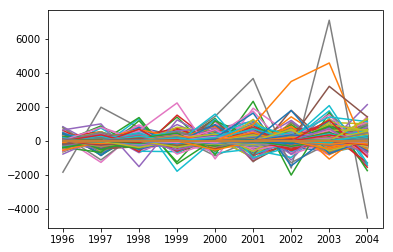

In [160]:
plt.plot(range(1996, 2005), test)
plt.show()

In [163]:
withDrawn = timeDeltas[timeDeltas['source'] == "grepafloxacin"] # 1999
withDrawn.head()

,source,target,delta1996,delta1997,delta1998,delta1999,delta2000,delta2001,delta2002,delta2003,delta2004
42724,grepafloxacin,gonococcal_infection,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42725,grepafloxacin,pneumoniae_infection,0.0,0.0,-34.0,0.0,0.0,0.0,0.0,0.0,0.0
44352,grepafloxacin,inflammatory_lung_diseases,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44353,grepafloxacin,convulsions,0.0,0.0,-18.0,0.0,0.0,0.0,0.0,0.0,0.0
44354,grepafloxacin,Shigella_dysenteriae_type_1_infection,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
withDrawn = timeDeltas[timeDeltas['source'] == "alosetron"] # 2000
withDrawn.head()

,source,target,delta1996,delta1997,delta1998,delta1999,delta2000,delta2001,delta2002,delta2003,delta2004
9546,alosetron,schizophrenia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67198,alosetron,irritable_bowel_syndrome,0.0,0.0,0.0,0.0,46.0,20.0,-66.0,6.0,0.0
76444,alosetron,depressor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76445,alosetron,colorectal_cancer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79013,alosetron,abdominal_pain,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0


In [165]:
withDrawn = timeDeltas[timeDeltas['source'] == "rosuvastatin"] # False
withDrawn.head()

,source,target,delta1996,delta1997,delta1998,delta1999,delta2000,delta2001,delta2002,delta2003,delta2004
86692,rosuvastatin,hypercholesterolemia,0.0,0.0,0.0,0.0,0.0,0.0,72.0,-71.0,160.0
87572,rosuvastatin,hypercholesterolemic,0.0,0.0,0.0,0.0,0.0,0.0,12.0,-21.0,32.0
87573,rosuvastatin,coronary_heart_disease,0.0,0.0,0.0,0.0,0.0,0.0,-49.0,35.0,-35.0
99551,rosuvastatin,atherosclerosis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-16.0
109491,rosuvastatin,endothelial_dysfunction,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
temp = timeDeltas[timeDeltas['delta2003'] > 3000.0]
temp

,source,target,delta1996,delta1997,delta1998,delta1999,delta2000,delta2001,delta2002,delta2003,delta2004
1167,tamoxifen,breast_tumor,-1843.0,1984.0,784.0,-73.0,1444.0,3677.0,-1596.0,7108.0,-4537.0
75861,CGP57148,CML,0.0,0.0,0.0,0.0,0.0,954.0,3501.0,4590.0,-717.0
85505,gefitinib,non-small_cell_lung_cancer,0.0,0.0,0.0,0.0,0.0,-37.0,112.0,3215.0,1414.0


In [90]:
G = nx.from_pandas_edgelist(test2, edge_attr=True)

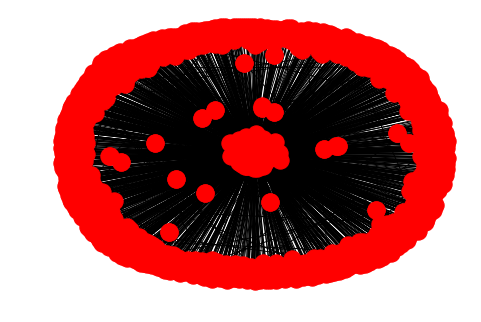

In [91]:
nx.draw(G)
plt.show()

In [92]:
largest_cc = max(nx.connected_components(G), key=len)

AttributeError: 'set' object has no attribute 'edges'

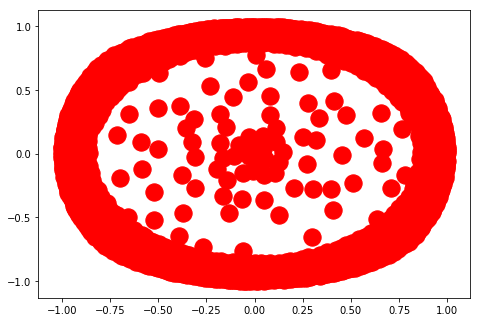

In [93]:
nx.draw(largest_cc)
plt.show()

In [52]:
test2.reset_index(inplace=True)

In [53]:
test2.head()

,level_0,level_1,0,1
0,edrophonium,presyncope,6,1
1,edrophonium,VVS,0,1
2,SO4_2,diabetes,0,30
3,SO4_2,impaired_renal_function,0,5
4,SO4_2,hepatobiliary_excretion,0,5
